# Nature Conservancy Monitoring

## Set up training, validation and testing schemes
Images are in Train and Test folders. The idea is to read all the training images in memory and dump into a numpy array on disk.
So that we waste very little time when experimenting from scratch.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import h5py
import cv2
import os
import glob
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Reshape, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import Adadelta, Adam
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, History
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from __future__ import division, print_function
from collections import Counter
%matplotlib inline

Using TensorFlow backend.


H:\Programs\Anaconda\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Create Validation directory

In [4]:
% cd J:/work/kaggle/201701_NCFM
% cd train_split

# pool_counter = 1

for fish_class in glob.glob('*'): os.mkdir('../valid_split/' + fish_class)

rnd_ord = np.random.permutation(glob.glob('*/*.jpg'))\
    
for i in range(500): os.rename(rnd_ord[i], '../valid_split/' + rnd_ord[i])

J:\work\kaggle\201701_NCFM
J:\work\kaggle\201701_NCFM\train_split


## VGG Batchnorm

In [2]:
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))
def vgg_preprocess(x):
    x = x - vgg_mean
    return x[:, ::-1]

def VGG_16(size=(224, 224), weights_path='J:/work/kaggle/201701_NCFM/vgg16_weights_th_dim_ordering_th_kernels.h5'):
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,)+size))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

    if weights_path:
        model.load_weights(weights_path)

    return model

## Finetune

In [3]:
size = (224, 224)
model = VGG_16(size=size)
#model.pop(); model.pop(); model.pop(); model.pop(); model.pop();
model.pop(); model.pop();

for layer in model.layers:
    layer.trainable = False

model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(8, activation='softmax'))

## Train, Validate generator

In [5]:
nb_train_samples = len(glob.glob('./train_split/*/*.jpg'))
nb_validation_samples = len(glob.glob('./valid_split/*/*.jpg'))
nb_epoch = 50
bath_size = 8
nb_test_samples = 1000

classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.1,
        rotation_range=10.,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
        './train_split/',
        target_size=size,
        batch_size=bath_size,
        shuffle=True,
        classes=classes,
        class_mode='categorical')

valid_datagen = ImageDataGenerator()

validation_generator = valid_datagen.flow_from_directory(
        './valid_split/',
        target_size=size,
        batch_size=bath_size,
        shuffle=True,
        classes=classes,
        class_mode='categorical')

callbacks = [EarlyStopping(monitor='val_loss', patience=1, verbose=0)]
model.compile(loss='categorical_crossentropy', optimizer="adadelta", 
              metrics=["accuracy"])

# fine-tune the model
hist = model.fit_generator(
        train_generator,
        samples_per_epoch=nb_train_samples,
        nb_epoch=nb_epoch,
        validation_data=validation_generator,
        nb_val_samples=nb_validation_samples,
        callbacks=callbacks)

Found 3277 images belonging to 8 classes.


Found 500 images belonging to 8 classes.


Epoch 1/50


   8/3277 [..............................] - ETA: 5431s - loss: 3.4112 - acc: 0.1250

  16/3277 [..............................] - ETA: 3057s - loss: 3.4584 - acc: 0.0625

  24/3277 [..............................] - ETA: 2265s - loss: 3.3470 - acc: 0.0833

  32/3277 [..............................] - ETA: 1868s - loss: 3.1622 - acc: 0.1250

  40/3277 [..............................] - ETA: 1629s - loss: 2.9803 - acc: 0.1750

  48/3277 [..............................] - ETA: 1469s - loss: 2.8969 - acc: 0.1875

  56/3277 [..............................] - ETA: 1354s - loss: 3.0091 - acc: 0.1607

  64/3277 [..............................] - ETA: 1268s - loss: 2.9445 - acc: 0.1719

  72/3277 [..............................] - ETA: 1200s - loss: 2.9572 - acc: 0.1806

  80/3277 [..............................] - ETA: 1146s - loss: 3.0267 - acc: 0.1750

  88/3277 [..............................] - ETA: 1101s - loss: 2.9435 - acc: 0.1818

  96/3277 [..............................] - ETA: 1063s - loss: 2.8936 - acc: 0.1771

 104/3277 [..............................] - ETA: 1031s - loss: 2.9252 - acc: 0.1827

 112/3277 [>.............................] - ETA: 1003s - loss: 2.9455 - acc: 0.1696

 120/3277 [>.............................] - ETA: 979s - loss: 2.9358 - acc: 0.1667 

 128/3277 [>.............................] - ETA: 958s - loss: 2.9226 - acc: 0.1797

 136/3277 [>.............................] - ETA: 938s - loss: 2.8904 - acc: 0.1838

 144/3277 [>.............................] - ETA: 921s - loss: 2.8708 - acc: 0.1806

 152/3277 [>.............................] - ETA: 906s - loss: 2.8483 - acc: 0.1908

 160/3277 [>.............................] - ETA: 891s - loss: 2.8592 - acc: 0.2000

 168/3277 [>.............................] - ETA: 878s - loss: 2.9074 - acc: 0.1964

 176/3277 [>.............................] - ETA: 867s - loss: 2.8537 - acc: 0.2102

 184/3277 [>.............................] - ETA: 855s - loss: 2.8675 - acc: 0.2011

 192/3277 [>.............................] - ETA: 845s - loss: 2.8651 - acc: 0.1979

 200/3277 [>.............................] - ETA: 836s - loss: 2.8186 - acc: 0.2100

 208/3277 [>.............................] - ETA: 827s - loss: 2.7979 - acc: 0.2163

 216/3277 [>.............................] - ETA: 819s - loss: 2.7416 - acc: 0.2361

 224/3277 [=>............................] - ETA: 812s - loss: 2.7247 - acc: 0.2366

 232/3277 [=>............................] - ETA: 805s - loss: 2.7399 - acc: 0.2328

 240/3277 [=>............................] - ETA: 799s - loss: 2.7254 - acc: 0.2375

 248/3277 [=>............................] - ETA: 793s - loss: 2.6886 - acc: 0.2419

 256/3277 [=>............................] - ETA: 787s - loss: 2.6927 - acc: 0.2344

 264/3277 [=>............................] - ETA: 782s - loss: 2.6673 - acc: 0.2424

 272/3277 [=>............................] - ETA: 777s - loss: 2.6515 - acc: 0.2500

 280/3277 [=>............................] - ETA: 772s - loss: 2.6610 - acc: 0.2536

 288/3277 [=>............................] - ETA: 768s - loss: 2.6834 - acc: 0.2569

 296/3277 [=>............................] - ETA: 763s - loss: 2.6934 - acc: 0.2500

 304/3277 [=>............................] - ETA: 759s - loss: 2.6653 - acc: 0.2599

 312/3277 [=>............................] - ETA: 755s - loss: 2.6566 - acc: 0.2596

 320/3277 [=>............................] - ETA: 752s - loss: 2.6684 - acc: 0.2625

 328/3277 [==>...........................] - ETA: 748s - loss: 2.6607 - acc: 0.2652

 336/3277 [==>...........................] - ETA: 745s - loss: 2.6387 - acc: 0.2708

 344/3277 [==>...........................] - ETA: 741s - loss: 2.6650 - acc: 0.2762

 352/3277 [==>...........................] - ETA: 738s - loss: 2.6363 - acc: 0.2812

 360/3277 [==>...........................] - ETA: 735s - loss: 2.6437 - acc: 0.2778

 368/3277 [==>...........................] - ETA: 731s - loss: 2.6368 - acc: 0.2772

 376/3277 [==>...........................] - ETA: 728s - loss: 2.6285 - acc: 0.2766

 384/3277 [==>...........................] - ETA: 726s - loss: 2.6376 - acc: 0.2734

 392/3277 [==>...........................] - ETA: 723s - loss: 2.6279 - acc: 0.2755

 400/3277 [==>...........................] - ETA: 720s - loss: 2.6167 - acc: 0.2750

 408/3277 [==>...........................] - ETA: 717s - loss: 2.6183 - acc: 0.2745

 416/3277 [==>...........................] - ETA: 715s - loss: 2.5963 - acc: 0.2788

 424/3277 [==>...........................] - ETA: 712s - loss: 2.5848 - acc: 0.2830

 432/3277 [==>...........................] - ETA: 710s - loss: 2.5497 - acc: 0.2917

 440/3277 [===>..........................] - ETA: 707s - loss: 2.5518 - acc: 0.2909

 448/3277 [===>..........................] - ETA: 705s - loss: 2.5331 - acc: 0.2946

 456/3277 [===>..........................] - ETA: 703s - loss: 2.5140 - acc: 0.3004

 464/3277 [===>..........................] - ETA: 700s - loss: 2.5093 - acc: 0.2996

 472/3277 [===>..........................] - ETA: 698s - loss: 2.5043 - acc: 0.2987

 480/3277 [===>..........................] - ETA: 696s - loss: 2.4943 - acc: 0.2979

 488/3277 [===>..........................] - ETA: 694s - loss: 2.4995 - acc: 0.2951

 496/3277 [===>..........................] - ETA: 691s - loss: 2.4918 - acc: 0.2984

 504/3277 [===>..........................] - ETA: 689s - loss: 2.4913 - acc: 0.2956

 512/3277 [===>..........................] - ETA: 687s - loss: 2.4932 - acc: 0.2910

 520/3277 [===>..........................] - ETA: 685s - loss: 2.4814 - acc: 0.2923

 528/3277 [===>..........................] - ETA: 683s - loss: 2.4879 - acc: 0.2917

 536/3277 [===>..........................] - ETA: 681s - loss: 2.4923 - acc: 0.2892

 544/3277 [===>..........................] - ETA: 679s - loss: 2.4845 - acc: 0.2904

 552/3277 [====>.........................] - ETA: 677s - loss: 2.4764 - acc: 0.2917

 560/3277 [====>.........................] - ETA: 675s - loss: 2.4606 - acc: 0.2946

 568/3277 [====>.........................] - ETA: 673s - loss: 2.4616 - acc: 0.2940

 576/3277 [====>.........................] - ETA: 671s - loss: 2.4518 - acc: 0.2951

 584/3277 [====>.........................] - ETA: 669s - loss: 2.4494 - acc: 0.2962

 592/3277 [====>.........................] - ETA: 667s - loss: 2.4480 - acc: 0.2939

 600/3277 [====>.........................] - ETA: 665s - loss: 2.4375 - acc: 0.2950

 608/3277 [====>.........................] - ETA: 663s - loss: 2.4273 - acc: 0.2977

 616/3277 [====>.........................] - ETA: 661s - loss: 2.4181 - acc: 0.2987

 624/3277 [====>.........................] - ETA: 659s - loss: 2.4234 - acc: 0.2997

 632/3277 [====>.........................] - ETA: 657s - loss: 2.4189 - acc: 0.3006

 640/3277 [====>.........................] - ETA: 655s - loss: 2.4113 - acc: 0.3047

 648/3277 [====>.........................] - ETA: 653s - loss: 2.3960 - acc: 0.3086

 656/3277 [=====>........................] - ETA: 651s - loss: 2.3842 - acc: 0.3125

 664/3277 [=====>........................] - ETA: 650s - loss: 2.3617 - acc: 0.3178

 672/3277 [=====>........................] - ETA: 648s - loss: 2.3537 - acc: 0.3199

 680/3277 [=====>........................] - ETA: 646s - loss: 2.3483 - acc: 0.3221

 688/3277 [=====>........................] - ETA: 644s - loss: 2.3528 - acc: 0.3227

 696/3277 [=====>........................] - ETA: 642s - loss: 2.3426 - acc: 0.3233

 704/3277 [=====>........................] - ETA: 640s - loss: 2.3400 - acc: 0.3253

 712/3277 [=====>........................] - ETA: 639s - loss: 2.3326 - acc: 0.3287

 720/3277 [=====>........................] - ETA: 637s - loss: 2.3304 - acc: 0.3319

 728/3277 [=====>........................] - ETA: 635s - loss: 2.3211 - acc: 0.3352

 736/3277 [=====>........................] - ETA: 633s - loss: 2.3075 - acc: 0.3383

 744/3277 [=====>........................] - ETA: 631s - loss: 2.3018 - acc: 0.3387

 752/3277 [=====>........................] - ETA: 629s - loss: 2.2968 - acc: 0.3404

 760/3277 [=====>........................] - ETA: 628s - loss: 2.2936 - acc: 0.3421

 768/3277 [======>.......................] - ETA: 626s - loss: 2.2776 - acc: 0.3477

 776/3277 [======>.......................] - ETA: 624s - loss: 2.2658 - acc: 0.3518

 784/3277 [======>.......................] - ETA: 622s - loss: 2.2596 - acc: 0.3520

 792/3277 [======>.......................] - ETA: 620s - loss: 2.2475 - acc: 0.3523

 800/3277 [======>.......................] - ETA: 618s - loss: 2.2448 - acc: 0.3525

 808/3277 [======>.......................] - ETA: 616s - loss: 2.2326 - acc: 0.3552

 816/3277 [======>.......................] - ETA: 615s - loss: 2.2252 - acc: 0.3578

 824/3277 [======>.......................] - ETA: 613s - loss: 2.2259 - acc: 0.3568

 832/3277 [======>.......................] - ETA: 611s - loss: 2.2166 - acc: 0.3582

 840/3277 [======>.......................] - ETA: 609s - loss: 2.2054 - acc: 0.3595

 848/3277 [======>.......................] - ETA: 608s - loss: 2.2014 - acc: 0.3620

 856/3277 [======>.......................] - ETA: 606s - loss: 2.2027 - acc: 0.3610

 864/3277 [======>.......................] - ETA: 604s - loss: 2.2073 - acc: 0.3588

 872/3277 [======>.......................] - ETA: 602s - loss: 2.1954 - acc: 0.3612

 880/3277 [=======>......................] - ETA: 601s - loss: 2.1963 - acc: 0.3625

 888/3277 [=======>......................] - ETA: 599s - loss: 2.1967 - acc: 0.3615

 896/3277 [=======>......................] - ETA: 597s - loss: 2.1915 - acc: 0.3616

 904/3277 [=======>......................] - ETA: 595s - loss: 2.1809 - acc: 0.3639

 912/3277 [=======>......................] - ETA: 594s - loss: 2.1777 - acc: 0.3651

 920/3277 [=======>......................] - ETA: 592s - loss: 2.1688 - acc: 0.3674

 928/3277 [=======>......................] - ETA: 590s - loss: 2.1694 - acc: 0.3675

 936/3277 [=======>......................] - ETA: 588s - loss: 2.1654 - acc: 0.3654

 944/3277 [=======>......................] - ETA: 586s - loss: 2.1570 - acc: 0.3676

 952/3277 [=======>......................] - ETA: 585s - loss: 2.1517 - acc: 0.3676

 960/3277 [=======>......................] - ETA: 583s - loss: 2.1586 - acc: 0.3656

 968/3277 [=======>......................] - ETA: 581s - loss: 2.1607 - acc: 0.3657

 976/3277 [=======>......................] - ETA: 579s - loss: 2.1660 - acc: 0.3637

 984/3277 [========>.....................] - ETA: 577s - loss: 2.1550 - acc: 0.3659

 992/3277 [========>.....................] - ETA: 575s - loss: 2.1453 - acc: 0.3679

1000/3277 [========>.....................] - ETA: 574s - loss: 2.1519 - acc: 0.3680

1008/3277 [========>.....................] - ETA: 572s - loss: 2.1415 - acc: 0.3710

1016/3277 [========>.....................] - ETA: 570s - loss: 2.1364 - acc: 0.3720

1024/3277 [========>.....................] - ETA: 568s - loss: 2.1460 - acc: 0.3721

1032/3277 [========>.....................] - ETA: 566s - loss: 2.1383 - acc: 0.3731

1040/3277 [========>.....................] - ETA: 565s - loss: 2.1358 - acc: 0.3731

1048/3277 [========>.....................] - ETA: 563s - loss: 2.1269 - acc: 0.3740

1056/3277 [========>.....................] - ETA: 561s - loss: 2.1214 - acc: 0.3750

1064/3277 [========>.....................] - ETA: 559s - loss: 2.1167 - acc: 0.3741

1072/3277 [========>.....................] - ETA: 558s - loss: 2.1223 - acc: 0.3722

1080/3277 [========>.....................] - ETA: 556s - loss: 2.1289 - acc: 0.3713

1088/3277 [========>.....................] - ETA: 554s - loss: 2.1226 - acc: 0.3732

1096/3277 [=========>....................] - ETA: 552s - loss: 2.1184 - acc: 0.3741

1104/3277 [=========>....................] - ETA: 550s - loss: 2.1206 - acc: 0.3732

1112/3277 [=========>....................] - ETA: 549s - loss: 2.1225 - acc: 0.3723

1120/3277 [=========>....................] - ETA: 547s - loss: 2.1195 - acc: 0.3723

1128/3277 [=========>....................] - ETA: 545s - loss: 2.1099 - acc: 0.3732

1136/3277 [=========>....................] - ETA: 543s - loss: 2.1064 - acc: 0.3741

1144/3277 [=========>....................] - ETA: 541s - loss: 2.1041 - acc: 0.3750

1152/3277 [=========>....................] - ETA: 540s - loss: 2.1045 - acc: 0.3759

1160/3277 [=========>....................] - ETA: 538s - loss: 2.1016 - acc: 0.3776

1168/3277 [=========>....................] - ETA: 536s - loss: 2.1087 - acc: 0.3759

1176/3277 [=========>....................] - ETA: 534s - loss: 2.1053 - acc: 0.3767

1184/3277 [=========>....................] - ETA: 532s - loss: 2.1041 - acc: 0.3775

1192/3277 [=========>....................] - ETA: 530s - loss: 2.1085 - acc: 0.3784

1200/3277 [=========>....................] - ETA: 529s - loss: 2.1043 - acc: 0.3792

1208/3277 [==========>...................] - ETA: 527s - loss: 2.1034 - acc: 0.3791

1216/3277 [==========>...................] - ETA: 525s - loss: 2.0975 - acc: 0.3799

1224/3277 [==========>...................] - ETA: 523s - loss: 2.0940 - acc: 0.3815

1232/3277 [==========>...................] - ETA: 521s - loss: 2.0923 - acc: 0.3815

1240/3277 [==========>...................] - ETA: 519s - loss: 2.0927 - acc: 0.3823

1248/3277 [==========>...................] - ETA: 517s - loss: 2.0868 - acc: 0.3846

1256/3277 [==========>...................] - ETA: 515s - loss: 2.0848 - acc: 0.3846

1264/3277 [==========>...................] - ETA: 514s - loss: 2.0823 - acc: 0.3861

1272/3277 [==========>...................] - ETA: 512s - loss: 2.0762 - acc: 0.3876

1280/3277 [==========>...................] - ETA: 510s - loss: 2.0733 - acc: 0.3891

1288/3277 [==========>...................] - ETA: 508s - loss: 2.0670 - acc: 0.3905

1296/3277 [==========>...................] - ETA: 506s - loss: 2.0645 - acc: 0.3920

1304/3277 [==========>...................] - ETA: 504s - loss: 2.0690 - acc: 0.3903

1312/3277 [===========>..................] - ETA: 502s - loss: 2.0672 - acc: 0.3902

1320/3277 [===========>..................] - ETA: 500s - loss: 2.0626 - acc: 0.3909

1328/3277 [===========>..................] - ETA: 498s - loss: 2.0630 - acc: 0.3916

1336/3277 [===========>..................] - ETA: 497s - loss: 2.0586 - acc: 0.3930

1344/3277 [===========>..................] - ETA: 495s - loss: 2.0531 - acc: 0.3943

1352/3277 [===========>..................] - ETA: 493s - loss: 2.0592 - acc: 0.3928

1360/3277 [===========>..................] - ETA: 491s - loss: 2.0633 - acc: 0.3919

1368/3277 [===========>..................] - ETA: 489s - loss: 2.0632 - acc: 0.3925

1376/3277 [===========>..................] - ETA: 487s - loss: 2.0565 - acc: 0.3946

1384/3277 [===========>..................] - ETA: 485s - loss: 2.0510 - acc: 0.3967

1392/3277 [===========>..................] - ETA: 483s - loss: 2.0458 - acc: 0.3980

1400/3277 [===========>..................] - ETA: 481s - loss: 2.0461 - acc: 0.3979

1408/3277 [===========>..................] - ETA: 479s - loss: 2.0434 - acc: 0.3984

1416/3277 [===========>..................] - ETA: 477s - loss: 2.0423 - acc: 0.3983

1424/3277 [============>.................] - ETA: 475s - loss: 2.0365 - acc: 0.3989

1432/3277 [============>.................] - ETA: 474s - loss: 2.0327 - acc: 0.4001

1440/3277 [============>.................] - ETA: 472s - loss: 2.0329 - acc: 0.4014

1448/3277 [============>.................] - ETA: 470s - loss: 2.0276 - acc: 0.4019

1456/3277 [============>.................] - ETA: 468s - loss: 2.0248 - acc: 0.4018

1464/3277 [============>.................] - ETA: 466s - loss: 2.0180 - acc: 0.4030

1472/3277 [============>.................] - ETA: 464s - loss: 2.0196 - acc: 0.4035

1480/3277 [============>.................] - ETA: 462s - loss: 2.0217 - acc: 0.4034

1488/3277 [============>.................] - ETA: 461s - loss: 2.0135 - acc: 0.4066

1496/3277 [============>.................] - ETA: 459s - loss: 2.0080 - acc: 0.4078

1504/3277 [============>.................] - ETA: 457s - loss: 2.0071 - acc: 0.4076

1512/3277 [============>.................] - ETA: 455s - loss: 2.0025 - acc: 0.4081

1520/3277 [============>.................] - ETA: 453s - loss: 2.0013 - acc: 0.4086

1528/3277 [============>.................] - ETA: 451s - loss: 1.9970 - acc: 0.4110

1536/3277 [=============>................] - ETA: 449s - loss: 1.9966 - acc: 0.4108

1544/3277 [=============>................] - ETA: 447s - loss: 1.9920 - acc: 0.4113

1552/3277 [=============>................] - ETA: 445s - loss: 1.9943 - acc: 0.4098

1560/3277 [=============>................] - ETA: 444s - loss: 1.9942 - acc: 0.4090

1568/3277 [=============>................] - ETA: 442s - loss: 1.9986 - acc: 0.4075

1576/3277 [=============>................] - ETA: 440s - loss: 2.0005 - acc: 0.4067

1584/3277 [=============>................] - ETA: 438s - loss: 2.0004 - acc: 0.4066

1592/3277 [=============>................] - ETA: 436s - loss: 2.0010 - acc: 0.4064

1600/3277 [=============>................] - ETA: 434s - loss: 2.0013 - acc: 0.4062

1608/3277 [=============>................] - ETA: 432s - loss: 1.9967 - acc: 0.4080

1616/3277 [=============>................] - ETA: 430s - loss: 1.9939 - acc: 0.4084

1624/3277 [=============>................] - ETA: 428s - loss: 1.9920 - acc: 0.4089

1632/3277 [=============>................] - ETA: 426s - loss: 1.9922 - acc: 0.4093

1640/3277 [==============>...............] - ETA: 424s - loss: 1.9864 - acc: 0.4104

1648/3277 [==============>...............] - ETA: 422s - loss: 1.9817 - acc: 0.4120

1656/3277 [==============>...............] - ETA: 420s - loss: 1.9791 - acc: 0.4124

1664/3277 [==============>...............] - ETA: 418s - loss: 1.9790 - acc: 0.4123

1672/3277 [==============>...............] - ETA: 416s - loss: 1.9798 - acc: 0.4127

1680/3277 [==============>...............] - ETA: 415s - loss: 1.9794 - acc: 0.4125

1688/3277 [==============>...............] - ETA: 413s - loss: 1.9723 - acc: 0.4147

1696/3277 [==============>...............] - ETA: 411s - loss: 1.9728 - acc: 0.4139

1704/3277 [==============>...............] - ETA: 409s - loss: 1.9718 - acc: 0.4137

1712/3277 [==============>...............] - ETA: 407s - loss: 1.9757 - acc: 0.4136

1720/3277 [==============>...............] - ETA: 405s - loss: 1.9761 - acc: 0.4140

1728/3277 [==============>...............] - ETA: 403s - loss: 1.9721 - acc: 0.4155

1736/3277 [==============>...............] - ETA: 401s - loss: 1.9732 - acc: 0.4153

1744/3277 [==============>...............] - ETA: 399s - loss: 1.9708 - acc: 0.4163

1752/3277 [===============>..............] - ETA: 397s - loss: 1.9672 - acc: 0.4178

1760/3277 [===============>..............] - ETA: 395s - loss: 1.9655 - acc: 0.4176

1768/3277 [===============>..............] - ETA: 393s - loss: 1.9613 - acc: 0.4180

1776/3277 [===============>..............] - ETA: 391s - loss: 1.9617 - acc: 0.4178

1784/3277 [===============>..............] - ETA: 389s - loss: 1.9612 - acc: 0.4176

1792/3277 [===============>..............] - ETA: 387s - loss: 1.9613 - acc: 0.4169

1800/3277 [===============>..............] - ETA: 385s - loss: 1.9584 - acc: 0.4172

1808/3277 [===============>..............] - ETA: 383s - loss: 1.9583 - acc: 0.4176

1816/3277 [===============>..............] - ETA: 381s - loss: 1.9583 - acc: 0.4180

1824/3277 [===============>..............] - ETA: 379s - loss: 1.9550 - acc: 0.4183

1832/3277 [===============>..............] - ETA: 377s - loss: 1.9569 - acc: 0.4176

1840/3277 [===============>..............] - ETA: 375s - loss: 1.9535 - acc: 0.4185

1848/3277 [===============>..............] - ETA: 373s - loss: 1.9526 - acc: 0.4188

1856/3277 [===============>..............] - ETA: 371s - loss: 1.9495 - acc: 0.4203

1864/3277 [================>.............] - ETA: 369s - loss: 1.9478 - acc: 0.4195

1872/3277 [================>.............] - ETA: 367s - loss: 1.9430 - acc: 0.4215

1880/3277 [================>.............] - ETA: 365s - loss: 1.9391 - acc: 0.4223

1888/3277 [================>.............] - ETA: 363s - loss: 1.9381 - acc: 0.4227

1896/3277 [================>.............] - ETA: 361s - loss: 1.9359 - acc: 0.4230

1904/3277 [================>.............] - ETA: 359s - loss: 1.9311 - acc: 0.4249

1912/3277 [================>.............] - ETA: 357s - loss: 1.9283 - acc: 0.4257

1920/3277 [================>.............] - ETA: 355s - loss: 1.9286 - acc: 0.4250

1928/3277 [================>.............] - ETA: 353s - loss: 1.9233 - acc: 0.4258

1936/3277 [================>.............] - ETA: 351s - loss: 1.9208 - acc: 0.4267

1944/3277 [================>.............] - ETA: 349s - loss: 1.9192 - acc: 0.4270

1952/3277 [================>.............] - ETA: 347s - loss: 1.9205 - acc: 0.4262

1960/3277 [================>.............] - ETA: 345s - loss: 1.9210 - acc: 0.4255

1968/3277 [=================>............] - ETA: 343s - loss: 1.9216 - acc: 0.4253

1976/3277 [=================>............] - ETA: 341s - loss: 1.9210 - acc: 0.4266

1984/3277 [=================>............] - ETA: 339s - loss: 1.9237 - acc: 0.4259

1992/3277 [=================>............] - ETA: 337s - loss: 1.9228 - acc: 0.4257

2000/3277 [=================>............] - ETA: 335s - loss: 1.9231 - acc: 0.4265

2008/3277 [=================>............] - ETA: 333s - loss: 1.9211 - acc: 0.4268

2016/3277 [=================>............] - ETA: 331s - loss: 1.9182 - acc: 0.4276

2024/3277 [=================>............] - ETA: 329s - loss: 1.9174 - acc: 0.4279

2032/3277 [=================>............] - ETA: 327s - loss: 1.9142 - acc: 0.4291

2040/3277 [=================>............] - ETA: 325s - loss: 1.9138 - acc: 0.4284

2048/3277 [=================>............] - ETA: 323s - loss: 1.9139 - acc: 0.4287

2056/3277 [=================>............] - ETA: 321s - loss: 1.9134 - acc: 0.4290

2064/3277 [=================>............] - ETA: 319s - loss: 1.9123 - acc: 0.4293

2072/3277 [=================>............] - ETA: 317s - loss: 1.9095 - acc: 0.4295

2080/3277 [==================>...........] - ETA: 315s - loss: 1.9087 - acc: 0.4293

2088/3277 [==================>...........] - ETA: 313s - loss: 1.9071 - acc: 0.4296

2096/3277 [==================>...........] - ETA: 311s - loss: 1.9043 - acc: 0.4299

2104/3277 [==================>...........] - ETA: 309s - loss: 1.9038 - acc: 0.4301

2112/3277 [==================>...........] - ETA: 307s - loss: 1.9025 - acc: 0.4299

2120/3277 [==================>...........] - ETA: 305s - loss: 1.8979 - acc: 0.4311

2128/3277 [==================>...........] - ETA: 303s - loss: 1.8965 - acc: 0.4314

2136/3277 [==================>...........] - ETA: 301s - loss: 1.8971 - acc: 0.4312

2144/3277 [==================>...........] - ETA: 299s - loss: 1.8933 - acc: 0.4319

2152/3277 [==================>...........] - ETA: 297s - loss: 1.8912 - acc: 0.4331

2160/3277 [==================>...........] - ETA: 295s - loss: 1.8869 - acc: 0.4347

2168/3277 [==================>...........] - ETA: 293s - loss: 1.8860 - acc: 0.4345

2176/3277 [==================>...........] - ETA: 291s - loss: 1.8820 - acc: 0.4361

2184/3277 [==================>...........] - ETA: 289s - loss: 1.8806 - acc: 0.4364

2192/3277 [===================>..........] - ETA: 287s - loss: 1.8807 - acc: 0.4366

2200/3277 [===================>..........] - ETA: 285s - loss: 1.8782 - acc: 0.4382

2208/3277 [===================>..........] - ETA: 283s - loss: 1.8780 - acc: 0.4380

2216/3277 [===================>..........] - ETA: 281s - loss: 1.8767 - acc: 0.4382

2224/3277 [===================>..........] - ETA: 279s - loss: 1.8736 - acc: 0.4393

2232/3277 [===================>..........] - ETA: 277s - loss: 1.8726 - acc: 0.4395

2240/3277 [===================>..........] - ETA: 275s - loss: 1.8745 - acc: 0.4388

2248/3277 [===================>..........] - ETA: 273s - loss: 1.8734 - acc: 0.4386

2256/3277 [===================>..........] - ETA: 271s - loss: 1.8709 - acc: 0.4384

2264/3277 [===================>..........] - ETA: 269s - loss: 1.8728 - acc: 0.4377

2272/3277 [===================>..........] - ETA: 267s - loss: 1.8678 - acc: 0.4388

2280/3277 [===================>..........] - ETA: 265s - loss: 1.8683 - acc: 0.4390

2288/3277 [===================>..........] - ETA: 263s - loss: 1.8677 - acc: 0.4384

2296/3277 [====================>.........] - ETA: 260s - loss: 1.8682 - acc: 0.4386

2304/3277 [====================>.........] - ETA: 258s - loss: 1.8634 - acc: 0.4401

2312/3277 [====================>.........] - ETA: 256s - loss: 1.8629 - acc: 0.4403

2320/3277 [====================>.........] - ETA: 254s - loss: 1.8594 - acc: 0.4409

2328/3277 [====================>.........] - ETA: 252s - loss: 1.8582 - acc: 0.4420

2336/3277 [====================>.........] - ETA: 250s - loss: 1.8546 - acc: 0.4426

2344/3277 [====================>.........] - ETA: 248s - loss: 1.8543 - acc: 0.4428

2352/3277 [====================>.........] - ETA: 246s - loss: 1.8510 - acc: 0.4439

2360/3277 [====================>.........] - ETA: 244s - loss: 1.8482 - acc: 0.4445

2368/3277 [====================>.........] - ETA: 242s - loss: 1.8444 - acc: 0.4459

2376/3277 [====================>.........] - ETA: 240s - loss: 1.8416 - acc: 0.4465

2384/3277 [====================>.........] - ETA: 238s - loss: 1.8425 - acc: 0.4463

2392/3277 [====================>.........] - ETA: 236s - loss: 1.8422 - acc: 0.4465

2400/3277 [====================>.........] - ETA: 234s - loss: 1.8417 - acc: 0.4462

2408/3277 [=====================>........] - ETA: 232s - loss: 1.8391 - acc: 0.4464

2416/3277 [=====================>........] - ETA: 229s - loss: 1.8364 - acc: 0.4478

2424/3277 [=====================>........] - ETA: 227s - loss: 1.8344 - acc: 0.4476

2432/3277 [=====================>........] - ETA: 225s - loss: 1.8331 - acc: 0.4482

2440/3277 [=====================>........] - ETA: 223s - loss: 1.8349 - acc: 0.4480

2448/3277 [=====================>........] - ETA: 221s - loss: 1.8314 - acc: 0.4485

2456/3277 [=====================>........] - ETA: 219s - loss: 1.8270 - acc: 0.4499

2464/3277 [=====================>........] - ETA: 217s - loss: 1.8254 - acc: 0.4501

2472/3277 [=====================>........] - ETA: 215s - loss: 1.8250 - acc: 0.4506

2480/3277 [=====================>........] - ETA: 213s - loss: 1.8231 - acc: 0.4508

2488/3277 [=====================>........] - ETA: 211s - loss: 1.8223 - acc: 0.4510

2496/3277 [=====================>........] - ETA: 209s - loss: 1.8195 - acc: 0.4515

2504/3277 [=====================>........] - ETA: 207s - loss: 1.8157 - acc: 0.4529

2512/3277 [=====================>........] - ETA: 204s - loss: 1.8146 - acc: 0.4526

2520/3277 [======================>.......] - ETA: 202s - loss: 1.8133 - acc: 0.4528

2528/3277 [======================>.......] - ETA: 200s - loss: 1.8132 - acc: 0.4533

2536/3277 [======================>.......] - ETA: 198s - loss: 1.8104 - acc: 0.4543

2544/3277 [======================>.......] - ETA: 196s - loss: 1.8133 - acc: 0.4536

2552/3277 [======================>.......] - ETA: 194s - loss: 1.8149 - acc: 0.4538

2560/3277 [======================>.......] - ETA: 192s - loss: 1.8115 - acc: 0.4551

2568/3277 [======================>.......] - ETA: 190s - loss: 1.8108 - acc: 0.4548

2576/3277 [======================>.......] - ETA: 188s - loss: 1.8098 - acc: 0.4550

2584/3277 [======================>.......] - ETA: 186s - loss: 1.8098 - acc: 0.4543

2592/3277 [======================>.......] - ETA: 183s - loss: 1.8098 - acc: 0.4541

2600/3277 [======================>.......] - ETA: 181s - loss: 1.8098 - acc: 0.4546

2608/3277 [======================>.......] - ETA: 179s - loss: 1.8068 - acc: 0.4555

2616/3277 [======================>.......] - ETA: 177s - loss: 1.8054 - acc: 0.4557

2624/3277 [=======================>......] - ETA: 175s - loss: 1.8039 - acc: 0.4554

2632/3277 [=======================>......] - ETA: 173s - loss: 1.8023 - acc: 0.4552

2640/3277 [=======================>......] - ETA: 171s - loss: 1.8024 - acc: 0.4545

2648/3277 [=======================>......] - ETA: 169s - loss: 1.8014 - acc: 0.4547

2656/3277 [=======================>......] - ETA: 167s - loss: 1.8010 - acc: 0.4544

2664/3277 [=======================>......] - ETA: 164s - loss: 1.8008 - acc: 0.4553

2672/3277 [=======================>......] - ETA: 162s - loss: 1.7985 - acc: 0.4562

2680/3277 [=======================>......] - ETA: 160s - loss: 1.7978 - acc: 0.4563

2688/3277 [=======================>......] - ETA: 158s - loss: 1.7962 - acc: 0.4561

2696/3277 [=======================>......] - ETA: 156s - loss: 1.7953 - acc: 0.4562

2704/3277 [=======================>......] - ETA: 154s - loss: 1.7964 - acc: 0.4560

2712/3277 [=======================>......] - ETA: 152s - loss: 1.7969 - acc: 0.4554

2720/3277 [=======================>......] - ETA: 150s - loss: 1.7975 - acc: 0.4551

2728/3277 [=======================>......] - ETA: 147s - loss: 1.7957 - acc: 0.4556

2736/3277 [========================>.....] - ETA: 145s - loss: 1.7974 - acc: 0.4547

2744/3277 [========================>.....] - ETA: 143s - loss: 1.7969 - acc: 0.4552

2752/3277 [========================>.....] - ETA: 141s - loss: 1.7959 - acc: 0.4549

2760/3277 [========================>.....] - ETA: 139s - loss: 1.7941 - acc: 0.4551

2768/3277 [========================>.....] - ETA: 137s - loss: 1.7927 - acc: 0.4559

2776/3277 [========================>.....] - ETA: 135s - loss: 1.7910 - acc: 0.4564

2784/3277 [========================>.....] - ETA: 133s - loss: 1.7895 - acc: 0.4569

2792/3277 [========================>.....] - ETA: 130s - loss: 1.7924 - acc: 0.4570

2800/3277 [========================>.....] - ETA: 128s - loss: 1.7893 - acc: 0.4582

2808/3277 [========================>.....] - ETA: 126s - loss: 1.7897 - acc: 0.4583

2816/3277 [========================>.....] - ETA: 124s - loss: 1.7916 - acc: 0.4577

2824/3277 [========================>.....] - ETA: 122s - loss: 1.7932 - acc: 0.4575

2832/3277 [========================>.....] - ETA: 120s - loss: 1.7915 - acc: 0.4583

2840/3277 [========================>.....] - ETA: 118s - loss: 1.7906 - acc: 0.4581

2848/3277 [=========================>....] - ETA: 115s - loss: 1.7882 - acc: 0.4582

2856/3277 [=========================>....] - ETA: 113s - loss: 1.7869 - acc: 0.4583

2864/3277 [=========================>....] - ETA: 111s - loss: 1.7859 - acc: 0.4591

2872/3277 [=========================>....] - ETA: 109s - loss: 1.7846 - acc: 0.4589

2880/3277 [=========================>....] - ETA: 107s - loss: 1.7841 - acc: 0.4594

2888/3277 [=========================>....] - ETA: 105s - loss: 1.7820 - acc: 0.4595

2896/3277 [=========================>....] - ETA: 103s - loss: 1.7803 - acc: 0.4596

2904/3277 [=========================>....] - ETA: 100s - loss: 1.7792 - acc: 0.4597

2912/3277 [=========================>....] - ETA: 98s - loss: 1.7781 - acc: 0.4602 

2920/3277 [=========================>....] - ETA: 96s - loss: 1.7768 - acc: 0.4606

2928/3277 [=========================>....] - ETA: 94s - loss: 1.7757 - acc: 0.4614

2936/3277 [=========================>....] - ETA: 92s - loss: 1.7732 - acc: 0.4619

2944/3277 [=========================>....] - ETA: 90s - loss: 1.7722 - acc: 0.4620

2952/3277 [==========================>...] - ETA: 88s - loss: 1.7709 - acc: 0.4624

2960/3277 [==========================>...] - ETA: 85s - loss: 1.7716 - acc: 0.4622

2968/3277 [==========================>...] - ETA: 83s - loss: 1.7682 - acc: 0.4633

2976/3277 [==========================>...] - ETA: 81s - loss: 1.7672 - acc: 0.4637

2984/3277 [==========================>...] - ETA: 79s - loss: 1.7652 - acc: 0.4638

2992/3277 [==========================>...] - ETA: 77s - loss: 1.7646 - acc: 0.4636

3000/3277 [==========================>...] - ETA: 75s - loss: 1.7650 - acc: 0.4637

3008/3277 [==========================>...] - ETA: 72s - loss: 1.7637 - acc: 0.4634

3016/3277 [==========================>...] - ETA: 70s - loss: 1.7644 - acc: 0.4629

3024/3277 [==========================>...] - ETA: 68s - loss: 1.7612 - acc: 0.4636

3032/3277 [==========================>...] - ETA: 66s - loss: 1.7615 - acc: 0.4634

3040/3277 [==========================>...] - ETA: 64s - loss: 1.7603 - acc: 0.4635

3048/3277 [==========================>...] - ETA: 62s - loss: 1.7600 - acc: 0.4629

3056/3277 [==========================>...] - ETA: 59s - loss: 1.7571 - acc: 0.4634

3064/3277 [===========================>..] - ETA: 57s - loss: 1.7556 - acc: 0.4641

3072/3277 [===========================>..] - ETA: 55s - loss: 1.7546 - acc: 0.4642

3080/3277 [===========================>..] - ETA: 53s - loss: 1.7538 - acc: 0.4646

3088/3277 [===========================>..] - ETA: 51s - loss: 1.7516 - acc: 0.4653

3096/3277 [===========================>..] - ETA: 49s - loss: 1.7510 - acc: 0.4648

3104/3277 [===========================>..] - ETA: 47s - loss: 1.7524 - acc: 0.4649

3112/3277 [===========================>..] - ETA: 44s - loss: 1.7525 - acc: 0.4650

3120/3277 [===========================>..] - ETA: 42s - loss: 1.7514 - acc: 0.4657

3128/3277 [===========================>..] - ETA: 40s - loss: 1.7493 - acc: 0.4664

3136/3277 [===========================>..] - ETA: 38s - loss: 1.7483 - acc: 0.4672

3144/3277 [===========================>..] - ETA: 36s - loss: 1.7479 - acc: 0.4669

3152/3277 [===========================>..] - ETA: 33s - loss: 1.7464 - acc: 0.4673

3160/3277 [===========================>..] - ETA: 31s - loss: 1.7459 - acc: 0.4674

3168/3277 [============================>.] - ETA: 29s - loss: 1.7462 - acc: 0.4672

3176/3277 [============================>.] - ETA: 27s - loss: 1.7465 - acc: 0.4669

3184/3277 [============================>.] - ETA: 25s - loss: 1.7466 - acc: 0.4667

3192/3277 [============================>.] - ETA: 23s - loss: 1.7448 - acc: 0.4674

3200/3277 [============================>.] - ETA: 20s - loss: 1.7437 - acc: 0.4678

3208/3277 [============================>.] - ETA: 18s - loss: 1.7438 - acc: 0.4679

3216/3277 [============================>.] - ETA: 16s - loss: 1.7437 - acc: 0.4680

3224/3277 [============================>.] - ETA: 14s - loss: 1.7415 - acc: 0.4687

3232/3277 [============================>.] - ETA: 12s - loss: 1.7388 - acc: 0.4697

3240/3277 [============================>.] - ETA: 10s - loss: 1.7377 - acc: 0.4694

3248/3277 [============================>.] - ETA: 7s - loss: 1.7348 - acc: 0.4701 

3256/3277 [============================>.] - ETA: 5s - loss: 1.7332 - acc: 0.4702

3264/3277 [============================>.] - ETA: 3s - loss: 1.7317 - acc: 0.4706

3272/3277 [============================>.] - ETA: 1s - loss: 1.7291 - acc: 0.4713

3277/3277 [==============================] - 1048s - loss: 1.7287 - acc: 0.4712 - val_loss: 1.0851 - val_acc: 0.6480


Epoch 2/50


   8/3277 [..............................] - ETA: 954s - loss: 0.8425 - acc: 0.6250

  16/3277 [..............................] - ETA: 952s - loss: 1.5383 - acc: 0.5625

  24/3277 [..............................] - ETA: 950s - loss: 1.2274 - acc: 0.6250

  32/3277 [..............................] - ETA: 948s - loss: 1.2681 - acc: 0.5938

  40/3277 [..............................] - ETA: 945s - loss: 1.1870 - acc: 0.6000

  48/3277 [..............................] - ETA: 943s - loss: 1.1393 - acc: 0.6042

  56/3277 [..............................] - ETA: 941s - loss: 1.0524 - acc: 0.6250

  64/3277 [..............................] - ETA: 939s - loss: 1.0412 - acc: 0.6250

  72/3277 [..............................] - ETA: 936s - loss: 1.0504 - acc: 0.6389

  80/3277 [..............................] - ETA: 934s - loss: 1.1632 - acc: 0.6000

  88/3277 [..............................] - ETA: 932s - loss: 1.1903 - acc: 0.5909

  96/3277 [..............................] - ETA: 929s - loss: 1.1869 - acc: 0.5833

 104/3277 [..............................] - ETA: 927s - loss: 1.2147 - acc: 0.5865

 112/3277 [>.............................] - ETA: 925s - loss: 1.2345 - acc: 0.5893

 120/3277 [>.............................] - ETA: 922s - loss: 1.2367 - acc: 0.5917

 128/3277 [>.............................] - ETA: 920s - loss: 1.1999 - acc: 0.6016

 136/3277 [>.............................] - ETA: 918s - loss: 1.1495 - acc: 0.6250

 144/3277 [>.............................] - ETA: 915s - loss: 1.1446 - acc: 0.6181

 152/3277 [>.............................] - ETA: 913s - loss: 1.1820 - acc: 0.6053

 160/3277 [>.............................] - ETA: 911s - loss: 1.1595 - acc: 0.6188

 168/3277 [>.............................] - ETA: 908s - loss: 1.1878 - acc: 0.6131

 176/3277 [>.............................] - ETA: 906s - loss: 1.1952 - acc: 0.6136

 184/3277 [>.............................] - ETA: 904s - loss: 1.1942 - acc: 0.6141

 192/3277 [>.............................] - ETA: 901s - loss: 1.1989 - acc: 0.6146

 200/3277 [>.............................] - ETA: 899s - loss: 1.1966 - acc: 0.6200

 208/3277 [>.............................] - ETA: 897s - loss: 1.2179 - acc: 0.6154

 216/3277 [>.............................] - ETA: 894s - loss: 1.2210 - acc: 0.6065

 224/3277 [=>............................] - ETA: 892s - loss: 1.2069 - acc: 0.6161

 232/3277 [=>............................] - ETA: 890s - loss: 1.2021 - acc: 0.6121

 240/3277 [=>............................] - ETA: 887s - loss: 1.1983 - acc: 0.6167

 248/3277 [=>............................] - ETA: 885s - loss: 1.2001 - acc: 0.6129

 256/3277 [=>............................] - ETA: 883s - loss: 1.2054 - acc: 0.6094

 264/3277 [=>............................] - ETA: 880s - loss: 1.2220 - acc: 0.6098

 272/3277 [=>............................] - ETA: 878s - loss: 1.2367 - acc: 0.6029

 280/3277 [=>............................] - ETA: 876s - loss: 1.2222 - acc: 0.6071

 288/3277 [=>............................] - ETA: 875s - loss: 1.2076 - acc: 0.6111

 296/3277 [=>............................] - ETA: 873s - loss: 1.2305 - acc: 0.6047

 304/3277 [=>............................] - ETA: 871s - loss: 1.2290 - acc: 0.5987

 312/3277 [=>............................] - ETA: 869s - loss: 1.2431 - acc: 0.5929

 320/3277 [=>............................] - ETA: 867s - loss: 1.2326 - acc: 0.5938

 328/3277 [==>...........................] - ETA: 865s - loss: 1.2256 - acc: 0.5945

 336/3277 [==>...........................] - ETA: 863s - loss: 1.2252 - acc: 0.5952

 344/3277 [==>...........................] - ETA: 861s - loss: 1.2264 - acc: 0.5930

 352/3277 [==>...........................] - ETA: 859s - loss: 1.2176 - acc: 0.5966

 360/3277 [==>...........................] - ETA: 857s - loss: 1.2159 - acc: 0.5972

 368/3277 [==>...........................] - ETA: 855s - loss: 1.2090 - acc: 0.6005

 376/3277 [==>...........................] - ETA: 853s - loss: 1.1957 - acc: 0.6090

 384/3277 [==>...........................] - ETA: 851s - loss: 1.1938 - acc: 0.6094

 392/3277 [==>...........................] - ETA: 849s - loss: 1.1921 - acc: 0.6122

 400/3277 [==>...........................] - ETA: 847s - loss: 1.1872 - acc: 0.6125

 408/3277 [==>...........................] - ETA: 844s - loss: 1.1836 - acc: 0.6152

 416/3277 [==>...........................] - ETA: 842s - loss: 1.1771 - acc: 0.6178

 424/3277 [==>...........................] - ETA: 840s - loss: 1.1770 - acc: 0.6179

 432/3277 [==>...........................] - ETA: 838s - loss: 1.1719 - acc: 0.6204

 440/3277 [===>..........................] - ETA: 836s - loss: 1.1640 - acc: 0.6205

 448/3277 [===>..........................] - ETA: 834s - loss: 1.1622 - acc: 0.6183

 456/3277 [===>..........................] - ETA: 831s - loss: 1.1826 - acc: 0.6118

 464/3277 [===>..........................] - ETA: 829s - loss: 1.1755 - acc: 0.6142

 472/3277 [===>..........................] - ETA: 827s - loss: 1.1800 - acc: 0.6165

 480/3277 [===>..........................] - ETA: 825s - loss: 1.1813 - acc: 0.6146

 488/3277 [===>..........................] - ETA: 823s - loss: 1.1827 - acc: 0.6148

 496/3277 [===>..........................] - ETA: 821s - loss: 1.1797 - acc: 0.6109

 504/3277 [===>..........................] - ETA: 818s - loss: 1.1757 - acc: 0.6151

 512/3277 [===>..........................] - ETA: 816s - loss: 1.1754 - acc: 0.6152

 520/3277 [===>..........................] - ETA: 814s - loss: 1.1636 - acc: 0.6192

 528/3277 [===>..........................] - ETA: 818s - loss: 1.1597 - acc: 0.6212

 536/3277 [===>..........................] - ETA: 822s - loss: 1.1523 - acc: 0.6231

 544/3277 [===>..........................] - ETA: 827s - loss: 1.1473 - acc: 0.6232

 552/3277 [====>.........................] - ETA: 831s - loss: 1.1604 - acc: 0.6196

 560/3277 [====>.........................] - ETA: 835s - loss: 1.1522 - acc: 0.6214

 568/3277 [====>.........................] - ETA: 839s - loss: 1.1435 - acc: 0.6250

 576/3277 [====>.........................] - ETA: 843s - loss: 1.1366 - acc: 0.6267

 584/3277 [====>.........................] - ETA: 846s - loss: 1.1398 - acc: 0.6250

 592/3277 [====>.........................] - ETA: 849s - loss: 1.1518 - acc: 0.6250

 600/3277 [====>.........................] - ETA: 846s - loss: 1.1474 - acc: 0.6250

 608/3277 [====>.........................] - ETA: 843s - loss: 1.1634 - acc: 0.6201

 616/3277 [====>.........................] - ETA: 840s - loss: 1.1665 - acc: 0.6169

 624/3277 [====>.........................] - ETA: 837s - loss: 1.1676 - acc: 0.6170

 632/3277 [====>.........................] - ETA: 834s - loss: 1.1693 - acc: 0.6171

 640/3277 [====>.........................] - ETA: 831s - loss: 1.1614 - acc: 0.6203

 648/3277 [====>.........................] - ETA: 828s - loss: 1.1589 - acc: 0.6235

 656/3277 [=====>........................] - ETA: 825s - loss: 1.1542 - acc: 0.6250

 664/3277 [=====>........................] - ETA: 822s - loss: 1.1691 - acc: 0.6235

 672/3277 [=====>........................] - ETA: 819s - loss: 1.1662 - acc: 0.6250

 680/3277 [=====>........................] - ETA: 816s - loss: 1.1627 - acc: 0.6250

 688/3277 [=====>........................] - ETA: 813s - loss: 1.1627 - acc: 0.6250

 696/3277 [=====>........................] - ETA: 810s - loss: 1.1674 - acc: 0.6236

 704/3277 [=====>........................] - ETA: 807s - loss: 1.1662 - acc: 0.6236

 712/3277 [=====>........................] - ETA: 804s - loss: 1.1700 - acc: 0.6236

 720/3277 [=====>........................] - ETA: 801s - loss: 1.1743 - acc: 0.6222

 728/3277 [=====>........................] - ETA: 798s - loss: 1.1809 - acc: 0.6195

 736/3277 [=====>........................] - ETA: 795s - loss: 1.1769 - acc: 0.6209

 744/3277 [=====>........................] - ETA: 792s - loss: 1.1831 - acc: 0.6210

 752/3277 [=====>........................] - ETA: 789s - loss: 1.1825 - acc: 0.6210

 760/3277 [=====>........................] - ETA: 786s - loss: 1.1859 - acc: 0.6197

 768/3277 [======>.......................] - ETA: 783s - loss: 1.1886 - acc: 0.6198

 776/3277 [======>.......................] - ETA: 781s - loss: 1.1887 - acc: 0.6198

 784/3277 [======>.......................] - ETA: 778s - loss: 1.1816 - acc: 0.6224

 792/3277 [======>.......................] - ETA: 775s - loss: 1.1804 - acc: 0.6212

 800/3277 [======>.......................] - ETA: 772s - loss: 1.1714 - acc: 0.6250

 808/3277 [======>.......................] - ETA: 769s - loss: 1.1668 - acc: 0.6250

 816/3277 [======>.......................] - ETA: 766s - loss: 1.1641 - acc: 0.6250

 824/3277 [======>.......................] - ETA: 764s - loss: 1.1763 - acc: 0.6226

 832/3277 [======>.......................] - ETA: 761s - loss: 1.1896 - acc: 0.6202

 840/3277 [======>.......................] - ETA: 758s - loss: 1.1875 - acc: 0.6202

 848/3277 [======>.......................] - ETA: 755s - loss: 1.1872 - acc: 0.6179

 856/3277 [======>.......................] - ETA: 752s - loss: 1.1818 - acc: 0.6203

 864/3277 [======>.......................] - ETA: 750s - loss: 1.1807 - acc: 0.6204

 872/3277 [======>.......................] - ETA: 747s - loss: 1.1805 - acc: 0.6204

 880/3277 [=======>......................] - ETA: 744s - loss: 1.1740 - acc: 0.6227

 888/3277 [=======>......................] - ETA: 741s - loss: 1.1730 - acc: 0.6227

 896/3277 [=======>......................] - ETA: 739s - loss: 1.1722 - acc: 0.6239

 904/3277 [=======>......................] - ETA: 736s - loss: 1.1750 - acc: 0.6228

 912/3277 [=======>......................] - ETA: 733s - loss: 1.1756 - acc: 0.6250

 920/3277 [=======>......................] - ETA: 731s - loss: 1.1750 - acc: 0.6250

 928/3277 [=======>......................] - ETA: 728s - loss: 1.1696 - acc: 0.6250

 936/3277 [=======>......................] - ETA: 725s - loss: 1.1646 - acc: 0.6250

 944/3277 [=======>......................] - ETA: 722s - loss: 1.1661 - acc: 0.6261

 952/3277 [=======>......................] - ETA: 720s - loss: 1.1716 - acc: 0.6239

 960/3277 [=======>......................] - ETA: 717s - loss: 1.1699 - acc: 0.6250

 968/3277 [=======>......................] - ETA: 714s - loss: 1.1671 - acc: 0.6260

 976/3277 [=======>......................] - ETA: 712s - loss: 1.1648 - acc: 0.6270

 984/3277 [========>.....................] - ETA: 709s - loss: 1.1723 - acc: 0.6260

 992/3277 [========>.....................] - ETA: 706s - loss: 1.1749 - acc: 0.6260

1000/3277 [========>.....................] - ETA: 704s - loss: 1.1735 - acc: 0.6260

1008/3277 [========>.....................] - ETA: 701s - loss: 1.1736 - acc: 0.6260

1016/3277 [========>.....................] - ETA: 698s - loss: 1.1742 - acc: 0.6240

1024/3277 [========>.....................] - ETA: 696s - loss: 1.1749 - acc: 0.6240

1032/3277 [========>.....................] - ETA: 693s - loss: 1.1811 - acc: 0.6221

1040/3277 [========>.....................] - ETA: 690s - loss: 1.1805 - acc: 0.6231

1048/3277 [========>.....................] - ETA: 688s - loss: 1.1814 - acc: 0.6221

1056/3277 [========>.....................] - ETA: 685s - loss: 1.1828 - acc: 0.6222

1064/3277 [========>.....................] - ETA: 682s - loss: 1.1804 - acc: 0.6203

1072/3277 [========>.....................] - ETA: 680s - loss: 1.1785 - acc: 0.6222

1080/3277 [========>.....................] - ETA: 677s - loss: 1.1800 - acc: 0.6213

1088/3277 [========>.....................] - ETA: 675s - loss: 1.1800 - acc: 0.6213

1096/3277 [=========>....................] - ETA: 672s - loss: 1.1826 - acc: 0.6204

1104/3277 [=========>....................] - ETA: 669s - loss: 1.1848 - acc: 0.6205

1112/3277 [=========>....................] - ETA: 667s - loss: 1.1826 - acc: 0.6214

1120/3277 [=========>....................] - ETA: 664s - loss: 1.1851 - acc: 0.6223

1128/3277 [=========>....................] - ETA: 661s - loss: 1.1886 - acc: 0.6215

1136/3277 [=========>....................] - ETA: 659s - loss: 1.1841 - acc: 0.6224

1144/3277 [=========>....................] - ETA: 656s - loss: 1.1849 - acc: 0.6215

1152/3277 [=========>....................] - ETA: 654s - loss: 1.1863 - acc: 0.6224

1160/3277 [=========>....................] - ETA: 651s - loss: 1.1866 - acc: 0.6233

1168/3277 [=========>....................] - ETA: 648s - loss: 1.1913 - acc: 0.6216

1176/3277 [=========>....................] - ETA: 646s - loss: 1.1917 - acc: 0.6216

1184/3277 [=========>....................] - ETA: 643s - loss: 1.1970 - acc: 0.6208

1192/3277 [=========>....................] - ETA: 641s - loss: 1.2045 - acc: 0.6191

1200/3277 [=========>....................] - ETA: 639s - loss: 1.2097 - acc: 0.6167

1208/3277 [==========>...................] - ETA: 639s - loss: 1.2113 - acc: 0.6159

1216/3277 [==========>...................] - ETA: 638s - loss: 1.2110 - acc: 0.6160

1224/3277 [==========>...................] - ETA: 638s - loss: 1.2134 - acc: 0.6152

1232/3277 [==========>...................] - ETA: 638s - loss: 1.2100 - acc: 0.6161

1240/3277 [==========>...................] - ETA: 637s - loss: 1.2092 - acc: 0.6161

1248/3277 [==========>...................] - ETA: 637s - loss: 1.2116 - acc: 0.6154

1256/3277 [==========>...................] - ETA: 636s - loss: 1.2113 - acc: 0.6146

1264/3277 [==========>...................] - ETA: 634s - loss: 1.2115 - acc: 0.6147

1272/3277 [==========>...................] - ETA: 632s - loss: 1.2138 - acc: 0.6124

1280/3277 [==========>...................] - ETA: 629s - loss: 1.2108 - acc: 0.6125

1288/3277 [==========>...................] - ETA: 626s - loss: 1.2163 - acc: 0.6110

1296/3277 [==========>...................] - ETA: 624s - loss: 1.2153 - acc: 0.6096

1304/3277 [==========>...................] - ETA: 621s - loss: 1.2130 - acc: 0.6097

1312/3277 [===========>..................] - ETA: 618s - loss: 1.2088 - acc: 0.6105

1320/3277 [===========>..................] - ETA: 615s - loss: 1.2092 - acc: 0.6098

1328/3277 [===========>..................] - ETA: 613s - loss: 1.2117 - acc: 0.6084

1336/3277 [===========>..................] - ETA: 610s - loss: 1.2179 - acc: 0.6063

1344/3277 [===========>..................] - ETA: 607s - loss: 1.2145 - acc: 0.6071

1352/3277 [===========>..................] - ETA: 605s - loss: 1.2156 - acc: 0.6065

1360/3277 [===========>..................] - ETA: 602s - loss: 1.2136 - acc: 0.6066

1368/3277 [===========>..................] - ETA: 599s - loss: 1.2133 - acc: 0.6067

1376/3277 [===========>..................] - ETA: 596s - loss: 1.2154 - acc: 0.6068

1384/3277 [===========>..................] - ETA: 594s - loss: 1.2112 - acc: 0.6084

1392/3277 [===========>..................] - ETA: 591s - loss: 1.2105 - acc: 0.6070

1400/3277 [===========>..................] - ETA: 588s - loss: 1.2113 - acc: 0.6071

1408/3277 [===========>..................] - ETA: 586s - loss: 1.2131 - acc: 0.6058

1416/3277 [===========>..................] - ETA: 583s - loss: 1.2105 - acc: 0.6073

1424/3277 [============>.................] - ETA: 580s - loss: 1.2092 - acc: 0.6074

1432/3277 [============>.................] - ETA: 578s - loss: 1.2092 - acc: 0.6068

1440/3277 [============>.................] - ETA: 575s - loss: 1.2090 - acc: 0.6069

1448/3277 [============>.................] - ETA: 572s - loss: 1.2061 - acc: 0.6077

1456/3277 [============>.................] - ETA: 570s - loss: 1.2047 - acc: 0.6078

1464/3277 [============>.................] - ETA: 567s - loss: 1.2024 - acc: 0.6086

1472/3277 [============>.................] - ETA: 565s - loss: 1.2035 - acc: 0.6087

1480/3277 [============>.................] - ETA: 562s - loss: 1.2037 - acc: 0.6081

1488/3277 [============>.................] - ETA: 559s - loss: 1.2054 - acc: 0.6075

1496/3277 [============>.................] - ETA: 557s - loss: 1.2031 - acc: 0.6090

1504/3277 [============>.................] - ETA: 554s - loss: 1.2034 - acc: 0.6084

1512/3277 [============>.................] - ETA: 551s - loss: 1.2003 - acc: 0.6091

1520/3277 [============>.................] - ETA: 549s - loss: 1.1998 - acc: 0.6086

1528/3277 [============>.................] - ETA: 546s - loss: 1.2011 - acc: 0.6080

1536/3277 [=============>................] - ETA: 543s - loss: 1.2022 - acc: 0.6081

1544/3277 [=============>................] - ETA: 541s - loss: 1.2058 - acc: 0.6062

1552/3277 [=============>................] - ETA: 538s - loss: 1.2098 - acc: 0.6050

1560/3277 [=============>................] - ETA: 536s - loss: 1.2145 - acc: 0.6038

1568/3277 [=============>................] - ETA: 533s - loss: 1.2131 - acc: 0.6046

1576/3277 [=============>................] - ETA: 530s - loss: 1.2152 - acc: 0.6047

1584/3277 [=============>................] - ETA: 528s - loss: 1.2167 - acc: 0.6048

1592/3277 [=============>................] - ETA: 525s - loss: 1.2173 - acc: 0.6049

1600/3277 [=============>................] - ETA: 522s - loss: 1.2208 - acc: 0.6031

1608/3277 [=============>................] - ETA: 520s - loss: 1.2193 - acc: 0.6039

1616/3277 [=============>................] - ETA: 517s - loss: 1.2166 - acc: 0.6046

1624/3277 [=============>................] - ETA: 515s - loss: 1.2141 - acc: 0.6041

1632/3277 [=============>................] - ETA: 512s - loss: 1.2152 - acc: 0.6036

1640/3277 [==============>...............] - ETA: 509s - loss: 1.2130 - acc: 0.6043

1648/3277 [==============>...............] - ETA: 507s - loss: 1.2130 - acc: 0.6044

1656/3277 [==============>...............] - ETA: 504s - loss: 1.2142 - acc: 0.6045

1664/3277 [==============>...............] - ETA: 502s - loss: 1.2151 - acc: 0.6034

1672/3277 [==============>...............] - ETA: 499s - loss: 1.2142 - acc: 0.6035

1680/3277 [==============>...............] - ETA: 497s - loss: 1.2179 - acc: 0.6024

1688/3277 [==============>...............] - ETA: 494s - loss: 1.2163 - acc: 0.6031

1696/3277 [==============>...............] - ETA: 491s - loss: 1.2158 - acc: 0.6026

1704/3277 [==============>...............] - ETA: 489s - loss: 1.2144 - acc: 0.6027

1712/3277 [==============>...............] - ETA: 486s - loss: 1.2158 - acc: 0.6011

1720/3277 [==============>...............] - ETA: 484s - loss: 1.2131 - acc: 0.6017

1728/3277 [==============>...............] - ETA: 481s - loss: 1.2117 - acc: 0.6013

1736/3277 [==============>...............] - ETA: 478s - loss: 1.2110 - acc: 0.6014

1744/3277 [==============>...............] - ETA: 476s - loss: 1.2101 - acc: 0.6009

1752/3277 [===============>..............] - ETA: 473s - loss: 1.2079 - acc: 0.6016

1760/3277 [===============>..............] - ETA: 471s - loss: 1.2084 - acc: 0.6011

1768/3277 [===============>..............] - ETA: 468s - loss: 1.2094 - acc: 0.6007

1776/3277 [===============>..............] - ETA: 466s - loss: 1.2112 - acc: 0.5991

1784/3277 [===============>..............] - ETA: 463s - loss: 1.2127 - acc: 0.5987

1792/3277 [===============>..............] - ETA: 460s - loss: 1.2139 - acc: 0.5982

1800/3277 [===============>..............] - ETA: 458s - loss: 1.2147 - acc: 0.5978

1808/3277 [===============>..............] - ETA: 455s - loss: 1.2155 - acc: 0.5973

1816/3277 [===============>..............] - ETA: 453s - loss: 1.2147 - acc: 0.5986

1824/3277 [===============>..............] - ETA: 450s - loss: 1.2154 - acc: 0.5987

1832/3277 [===============>..............] - ETA: 448s - loss: 1.2146 - acc: 0.5988

1840/3277 [===============>..............] - ETA: 445s - loss: 1.2121 - acc: 0.5995

1848/3277 [===============>..............] - ETA: 443s - loss: 1.2130 - acc: 0.5990

1856/3277 [===============>..............] - ETA: 440s - loss: 1.2136 - acc: 0.5991

1864/3277 [================>.............] - ETA: 437s - loss: 1.2156 - acc: 0.5992

1872/3277 [================>.............] - ETA: 435s - loss: 1.2141 - acc: 0.5999

1880/3277 [================>.............] - ETA: 432s - loss: 1.2126 - acc: 0.6005

1888/3277 [================>.............] - ETA: 430s - loss: 1.2112 - acc: 0.6017

1896/3277 [================>.............] - ETA: 427s - loss: 1.2160 - acc: 0.6013

1904/3277 [================>.............] - ETA: 425s - loss: 1.2162 - acc: 0.6019

1912/3277 [================>.............] - ETA: 422s - loss: 1.2182 - acc: 0.6015

1920/3277 [================>.............] - ETA: 420s - loss: 1.2203 - acc: 0.6010

1928/3277 [================>.............] - ETA: 417s - loss: 1.2177 - acc: 0.6017

1936/3277 [================>.............] - ETA: 415s - loss: 1.2179 - acc: 0.6012

1944/3277 [================>.............] - ETA: 412s - loss: 1.2166 - acc: 0.6019

1952/3277 [================>.............] - ETA: 410s - loss: 1.2175 - acc: 0.6019

1960/3277 [================>.............] - ETA: 407s - loss: 1.2155 - acc: 0.6020

1968/3277 [=================>............] - ETA: 404s - loss: 1.2140 - acc: 0.6026

1976/3277 [=================>............] - ETA: 402s - loss: 1.2129 - acc: 0.6032

1984/3277 [=================>............] - ETA: 399s - loss: 1.2133 - acc: 0.6033

1992/3277 [=================>............] - ETA: 397s - loss: 1.2156 - acc: 0.6029

2000/3277 [=================>............] - ETA: 394s - loss: 1.2153 - acc: 0.6030

2008/3277 [=================>............] - ETA: 392s - loss: 1.2153 - acc: 0.6031

2016/3277 [=================>............] - ETA: 389s - loss: 1.2134 - acc: 0.6037

2024/3277 [=================>............] - ETA: 387s - loss: 1.2179 - acc: 0.6023

2032/3277 [=================>............] - ETA: 384s - loss: 1.2183 - acc: 0.6014

2040/3277 [=================>............] - ETA: 382s - loss: 1.2159 - acc: 0.6025

2048/3277 [=================>............] - ETA: 379s - loss: 1.2158 - acc: 0.6025

2056/3277 [=================>............] - ETA: 377s - loss: 1.2171 - acc: 0.6012

2064/3277 [=================>............] - ETA: 374s - loss: 1.2161 - acc: 0.6008

2072/3277 [=================>............] - ETA: 372s - loss: 1.2155 - acc: 0.6009

2080/3277 [==================>...........] - ETA: 369s - loss: 1.2121 - acc: 0.6024

2088/3277 [==================>...........] - ETA: 367s - loss: 1.2122 - acc: 0.6025

2096/3277 [==================>...........] - ETA: 364s - loss: 1.2107 - acc: 0.6026

2104/3277 [==================>...........] - ETA: 362s - loss: 1.2130 - acc: 0.6017

2112/3277 [==================>...........] - ETA: 359s - loss: 1.2130 - acc: 0.6018

2120/3277 [==================>...........] - ETA: 357s - loss: 1.2122 - acc: 0.6024

2128/3277 [==================>...........] - ETA: 354s - loss: 1.2114 - acc: 0.6029

2136/3277 [==================>...........] - ETA: 352s - loss: 1.2116 - acc: 0.6035

2144/3277 [==================>...........] - ETA: 349s - loss: 1.2138 - acc: 0.6021

2152/3277 [==================>...........] - ETA: 346s - loss: 1.2145 - acc: 0.6022

2160/3277 [==================>...........] - ETA: 344s - loss: 1.2170 - acc: 0.6014

2168/3277 [==================>...........] - ETA: 341s - loss: 1.2161 - acc: 0.6006

2176/3277 [==================>...........] - ETA: 339s - loss: 1.2136 - acc: 0.6011

2184/3277 [==================>...........] - ETA: 336s - loss: 1.2121 - acc: 0.6016

2192/3277 [===================>..........] - ETA: 334s - loss: 1.2151 - acc: 0.6008

2200/3277 [===================>..........] - ETA: 331s - loss: 1.2149 - acc: 0.6005

2208/3277 [===================>..........] - ETA: 329s - loss: 1.2141 - acc: 0.6010

2216/3277 [===================>..........] - ETA: 326s - loss: 1.2140 - acc: 0.6006

2224/3277 [===================>..........] - ETA: 324s - loss: 1.2108 - acc: 0.6016

2232/3277 [===================>..........] - ETA: 321s - loss: 1.2086 - acc: 0.6022

2240/3277 [===================>..........] - ETA: 319s - loss: 1.2081 - acc: 0.6022

2248/3277 [===================>..........] - ETA: 316s - loss: 1.2062 - acc: 0.6032

2256/3277 [===================>..........] - ETA: 314s - loss: 1.2061 - acc: 0.6033

2264/3277 [===================>..........] - ETA: 311s - loss: 1.2042 - acc: 0.6038

2272/3277 [===================>..........] - ETA: 309s - loss: 1.2043 - acc: 0.6039

2280/3277 [===================>..........] - ETA: 306s - loss: 1.2024 - acc: 0.6044

2288/3277 [===================>..........] - ETA: 304s - loss: 1.2015 - acc: 0.6045

2296/3277 [====================>.........] - ETA: 301s - loss: 1.2060 - acc: 0.6032

2304/3277 [====================>.........] - ETA: 299s - loss: 1.2061 - acc: 0.6033

2312/3277 [====================>.........] - ETA: 296s - loss: 1.2038 - acc: 0.6042

2320/3277 [====================>.........] - ETA: 294s - loss: 1.2039 - acc: 0.6039

2328/3277 [====================>.........] - ETA: 292s - loss: 1.2016 - acc: 0.6044

2336/3277 [====================>.........] - ETA: 289s - loss: 1.2002 - acc: 0.6049

2344/3277 [====================>.........] - ETA: 287s - loss: 1.2005 - acc: 0.6049

2352/3277 [====================>.........] - ETA: 284s - loss: 1.1981 - acc: 0.6059

2360/3277 [====================>.........] - ETA: 282s - loss: 1.1984 - acc: 0.6059

2368/3277 [====================>.........] - ETA: 279s - loss: 1.1977 - acc: 0.6060

2376/3277 [====================>.........] - ETA: 277s - loss: 1.1972 - acc: 0.6056

2384/3277 [====================>.........] - ETA: 274s - loss: 1.1952 - acc: 0.6065

2392/3277 [====================>.........] - ETA: 272s - loss: 1.1960 - acc: 0.6066

2400/3277 [====================>.........] - ETA: 269s - loss: 1.1950 - acc: 0.6067

2408/3277 [=====================>........] - ETA: 267s - loss: 1.1931 - acc: 0.6076

2416/3277 [=====================>........] - ETA: 264s - loss: 1.1926 - acc: 0.6076

2424/3277 [=====================>........] - ETA: 262s - loss: 1.1914 - acc: 0.6081

2432/3277 [=====================>........] - ETA: 259s - loss: 1.1920 - acc: 0.6077

2440/3277 [=====================>........] - ETA: 257s - loss: 1.1917 - acc: 0.6070

2448/3277 [=====================>........] - ETA: 255s - loss: 1.1917 - acc: 0.6062

2456/3277 [=====================>........] - ETA: 253s - loss: 1.1898 - acc: 0.6067

2464/3277 [=====================>........] - ETA: 251s - loss: 1.1908 - acc: 0.6067

2472/3277 [=====================>........] - ETA: 249s - loss: 1.1896 - acc: 0.6072

2480/3277 [=====================>........] - ETA: 247s - loss: 1.1912 - acc: 0.6073

2488/3277 [=====================>........] - ETA: 245s - loss: 1.1918 - acc: 0.6069

2496/3277 [=====================>........] - ETA: 243s - loss: 1.1924 - acc: 0.6058

2504/3277 [=====================>........] - ETA: 241s - loss: 1.1930 - acc: 0.6058

2512/3277 [=====================>........] - ETA: 238s - loss: 1.1940 - acc: 0.6055

2520/3277 [======================>.......] - ETA: 236s - loss: 1.1949 - acc: 0.6052

2528/3277 [======================>.......] - ETA: 233s - loss: 1.1960 - acc: 0.6052

2536/3277 [======================>.......] - ETA: 231s - loss: 1.1959 - acc: 0.6053

2544/3277 [======================>.......] - ETA: 228s - loss: 1.1970 - acc: 0.6053

2552/3277 [======================>.......] - ETA: 226s - loss: 1.1966 - acc: 0.6058

2560/3277 [======================>.......] - ETA: 223s - loss: 1.1977 - acc: 0.6051

2568/3277 [======================>.......] - ETA: 221s - loss: 1.1997 - acc: 0.6048

2576/3277 [======================>.......] - ETA: 218s - loss: 1.2003 - acc: 0.6044

2584/3277 [======================>.......] - ETA: 216s - loss: 1.2043 - acc: 0.6033

2592/3277 [======================>.......] - ETA: 213s - loss: 1.2044 - acc: 0.6038

2600/3277 [======================>.......] - ETA: 210s - loss: 1.2036 - acc: 0.6035

2608/3277 [======================>.......] - ETA: 208s - loss: 1.2036 - acc: 0.6031

2616/3277 [======================>.......] - ETA: 205s - loss: 1.2028 - acc: 0.6040

2624/3277 [=======================>......] - ETA: 203s - loss: 1.2015 - acc: 0.6044

2632/3277 [=======================>......] - ETA: 200s - loss: 1.2026 - acc: 0.6037

2640/3277 [=======================>......] - ETA: 198s - loss: 1.1999 - acc: 0.6045

2648/3277 [=======================>......] - ETA: 195s - loss: 1.1970 - acc: 0.6057

2656/3277 [=======================>......] - ETA: 193s - loss: 1.1976 - acc: 0.6058

2664/3277 [=======================>......] - ETA: 190s - loss: 1.1959 - acc: 0.6066

2672/3277 [=======================>......] - ETA: 188s - loss: 1.1961 - acc: 0.6067

2680/3277 [=======================>......] - ETA: 185s - loss: 1.1955 - acc: 0.6075

2688/3277 [=======================>......] - ETA: 183s - loss: 1.1942 - acc: 0.6079

2696/3277 [=======================>......] - ETA: 180s - loss: 1.1939 - acc: 0.6076

2704/3277 [=======================>......] - ETA: 178s - loss: 1.1946 - acc: 0.6072

2712/3277 [=======================>......] - ETA: 175s - loss: 1.1936 - acc: 0.6077

2720/3277 [=======================>......] - ETA: 173s - loss: 1.1931 - acc: 0.6074

2728/3277 [=======================>......] - ETA: 170s - loss: 1.1914 - acc: 0.6074

2736/3277 [========================>.....] - ETA: 168s - loss: 1.1909 - acc: 0.6078

2744/3277 [========================>.....] - ETA: 165s - loss: 1.1926 - acc: 0.6079

2752/3277 [========================>.....] - ETA: 163s - loss: 1.1915 - acc: 0.6086

2760/3277 [========================>.....] - ETA: 161s - loss: 1.1900 - acc: 0.6094

2768/3277 [========================>.....] - ETA: 159s - loss: 1.1890 - acc: 0.6095

2776/3277 [========================>.....] - ETA: 156s - loss: 1.1901 - acc: 0.6088

2784/3277 [========================>.....] - ETA: 154s - loss: 1.1915 - acc: 0.6085

2792/3277 [========================>.....] - ETA: 152s - loss: 1.1898 - acc: 0.6092

2800/3277 [========================>.....] - ETA: 150s - loss: 1.1881 - acc: 0.6096

2808/3277 [========================>.....] - ETA: 147s - loss: 1.1867 - acc: 0.6100

2816/3277 [========================>.....] - ETA: 145s - loss: 1.1856 - acc: 0.6104

2824/3277 [========================>.....] - ETA: 143s - loss: 1.1837 - acc: 0.6112

2832/3277 [========================>.....] - ETA: 140s - loss: 1.1840 - acc: 0.6109

2840/3277 [========================>.....] - ETA: 138s - loss: 1.1829 - acc: 0.6113

2848/3277 [=========================>....] - ETA: 136s - loss: 1.1840 - acc: 0.6103

2856/3277 [=========================>....] - ETA: 133s - loss: 1.1814 - acc: 0.6113

2864/3277 [=========================>....] - ETA: 131s - loss: 1.1816 - acc: 0.6110

2872/3277 [=========================>....] - ETA: 128s - loss: 1.1832 - acc: 0.6111

2880/3277 [=========================>....] - ETA: 125s - loss: 1.1830 - acc: 0.6111

2888/3277 [=========================>....] - ETA: 123s - loss: 1.1856 - acc: 0.6101

2896/3277 [=========================>....] - ETA: 120s - loss: 1.1850 - acc: 0.6102

2904/3277 [=========================>....] - ETA: 118s - loss: 1.1837 - acc: 0.6102

2912/3277 [=========================>....] - ETA: 115s - loss: 1.1834 - acc: 0.6102

2920/3277 [=========================>....] - ETA: 113s - loss: 1.1852 - acc: 0.6092

2928/3277 [=========================>....] - ETA: 110s - loss: 1.1835 - acc: 0.6100

2936/3277 [=========================>....] - ETA: 108s - loss: 1.1843 - acc: 0.6100

2944/3277 [=========================>....] - ETA: 105s - loss: 1.1826 - acc: 0.6107

2952/3277 [==========================>...] - ETA: 102s - loss: 1.1831 - acc: 0.6108

2960/3277 [==========================>...] - ETA: 100s - loss: 1.1833 - acc: 0.6111

2968/3277 [==========================>...] - ETA: 97s - loss: 1.1817 - acc: 0.6119 

2976/3277 [==========================>...] - ETA: 95s - loss: 1.1825 - acc: 0.6112

2984/3277 [==========================>...] - ETA: 92s - loss: 1.1827 - acc: 0.6113

2992/3277 [==========================>...] - ETA: 90s - loss: 1.1833 - acc: 0.6110

3000/3277 [==========================>...] - ETA: 87s - loss: 1.1827 - acc: 0.6113

3008/3277 [==========================>...] - ETA: 85s - loss: 1.1849 - acc: 0.6114

3016/3277 [==========================>...] - ETA: 82s - loss: 1.1861 - acc: 0.6114

3024/3277 [==========================>...] - ETA: 80s - loss: 1.1873 - acc: 0.6111

3032/3277 [==========================>...] - ETA: 77s - loss: 1.1855 - acc: 0.6118

3040/3277 [==========================>...] - ETA: 75s - loss: 1.1848 - acc: 0.6122

3048/3277 [==========================>...] - ETA: 73s - loss: 1.1848 - acc: 0.6125

3056/3277 [==========================>...] - ETA: 70s - loss: 1.1862 - acc: 0.6122

3064/3277 [===========================>..] - ETA: 67s - loss: 1.1862 - acc: 0.6126

3072/3277 [===========================>..] - ETA: 65s - loss: 1.1846 - acc: 0.6130

3080/3277 [===========================>..] - ETA: 62s - loss: 1.1835 - acc: 0.6133

3088/3277 [===========================>..] - ETA: 60s - loss: 1.1853 - acc: 0.6130

3096/3277 [===========================>..] - ETA: 57s - loss: 1.1837 - acc: 0.6137

3104/3277 [===========================>..] - ETA: 55s - loss: 1.1842 - acc: 0.6137

3112/3277 [===========================>..] - ETA: 52s - loss: 1.1834 - acc: 0.6138

3120/3277 [===========================>..] - ETA: 50s - loss: 1.1830 - acc: 0.6135

3128/3277 [===========================>..] - ETA: 47s - loss: 1.1830 - acc: 0.6135

3136/3277 [===========================>..] - ETA: 44s - loss: 1.1826 - acc: 0.6135

3144/3277 [===========================>..] - ETA: 42s - loss: 1.1818 - acc: 0.6135

3152/3277 [===========================>..] - ETA: 39s - loss: 1.1829 - acc: 0.6133

3160/3277 [===========================>..] - ETA: 37s - loss: 1.1821 - acc: 0.6133

3168/3277 [============================>.] - ETA: 34s - loss: 1.1813 - acc: 0.6136

3176/3277 [============================>.] - ETA: 32s - loss: 1.1795 - acc: 0.6146

3184/3277 [============================>.] - ETA: 29s - loss: 1.1785 - acc: 0.6153

3192/3277 [============================>.] - ETA: 27s - loss: 1.1785 - acc: 0.6156

3200/3277 [============================>.] - ETA: 24s - loss: 1.1785 - acc: 0.6156

3208/3277 [============================>.] - ETA: 21s - loss: 1.1804 - acc: 0.6150

3216/3277 [============================>.] - ETA: 19s - loss: 1.1802 - acc: 0.6150

3224/3277 [============================>.] - ETA: 16s - loss: 1.1790 - acc: 0.6157

3232/3277 [============================>.] - ETA: 14s - loss: 1.1777 - acc: 0.6160

3240/3277 [============================>.] - ETA: 11s - loss: 1.1771 - acc: 0.6164

3248/3277 [============================>.] - ETA: 9s - loss: 1.1763 - acc: 0.6167 

3256/3277 [============================>.] - ETA: 6s - loss: 1.1753 - acc: 0.6170

3264/3277 [============================>.] - ETA: 4s - loss: 1.1754 - acc: 0.6170

3272/3277 [============================>.] - ETA: 1s - loss: 1.1771 - acc: 0.6164

3277/3277 [==============================] - 1188s - loss: 1.1764 - acc: 0.6167 - val_loss: 0.7836 - val_acc: 0.7300


Epoch 3/50


   8/3277 [..............................] - ETA: 975s - loss: 1.2532 - acc: 0.2500

  16/3277 [..............................] - ETA: 973s - loss: 1.4939 - acc: 0.4375

  24/3277 [..............................] - ETA: 971s - loss: 1.5151 - acc: 0.5417

  32/3277 [..............................] - ETA: 968s - loss: 1.2644 - acc: 0.6250

  40/3277 [..............................] - ETA: 966s - loss: 1.1596 - acc: 0.6250

## Plots

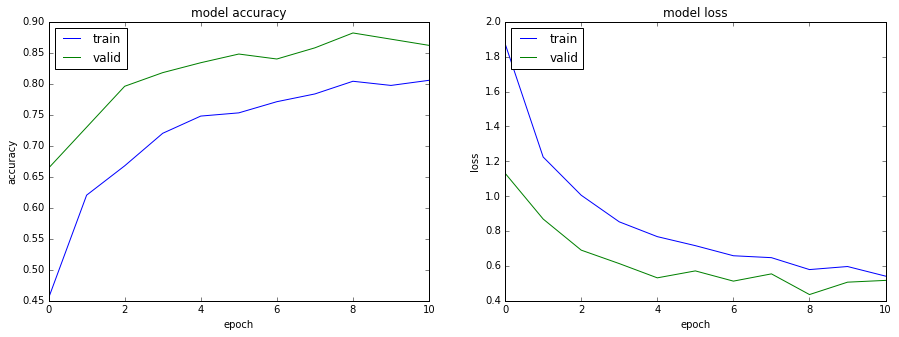

In [6]:
# summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['acc']); plt.plot(hist.history['val_acc']);
plt.title('model accuracy'); plt.ylabel('accuracy');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss']); plt.plot(hist.history['val_loss']);
plt.title('model loss'); plt.ylabel('loss');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');
plt.show()

In [7]:
model.save_weights('../pickles/vgg16_aug_lessdrop.pkl')

## Test generator

In [9]:
test_aug = 5
test_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.1,
        rotation_range=10.,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)

for aug in range(test_aug):
    print('Predictions for Augmented -', aug)
    random_seed = np.random.random_integers(0, 100000)

    test_generator = test_datagen.flow_from_directory(
            '../test/',
            target_size=size,
            batch_size=bath_size,
            shuffle = False,
            seed = random_seed,
            classes = None,
            class_mode = None)

    test_image_list = test_generator.filenames
    if aug == 0:
        predictions = model.predict_generator(test_generator, nb_test_samples)
    else:
        predictions += model.predict_generator(test_generator, nb_test_samples)

predictions /= test_aug

Predictions for Augmented - 0
Found 1000 images belonging to 1 classes.
Predictions for Augmented - 1
Found 1000 images belonging to 1 classes.
Predictions for Augmented - 2
Found 1000 images belonging to 1 classes.
Predictions for Augmented - 3
Found 1000 images belonging to 1 classes.
Predictions for Augmented - 4
Found 1000 images belonging to 1 classes.


## Predictions

In [10]:
# clip predictions
c = 0
preds = np.clip(predictions, c, 1-c)

print('Begin to write submission file ..')
f_submit = open(os.path.join('/home/trooper/Documents/Nature/pooled', \
                             'submit_' + str(pool_counter) +'.csv'), 'w')
f_submit.write('image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT\n')
for i, image_name in enumerate(test_generator.filenames):
    pred = ['%.6f' % p for p in preds[i, :]]
    if i%100 == 0:
        print(i, '/', 1000)
    f_submit.write('%s,%s\n' % (os.path.basename(image_name), ','.join(pred)))

f_submit.close()

Begin to write submission file ..
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
